In [93]:
import warnings
warnings.simplefilter('ignore')

import pandas as pd 
import os
import matplotlib.pyplot as plt
import plotly.express as px

---

# 00 Initial Analysis 

In [94]:
target_ts = '2min.parquet'

cwd = os.getcwd()
meta_data = os.path.join(cwd, "..", "data", "raw_data", "metadata.csv")
time_series = os.path.join(cwd, "..", "data", "raw_data", target_ts)

df_energy = pd.read_parquet(time_series)
df_spec = pd.read_csv(meta_data)

gcs_path = 'gs://energy-supply-time-series-data/30min_energy_supply_data.parquet'

df_spec.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [177]:
df_energy.to_csv('2min_generation.csv')

In [95]:
len(df_energy)

558135324

In [135]:
df_energy.ss_id.nunique()

1380

In [96]:
# Filtering out by hourly intervals only
df_energy = df_energy[(df_energy['timestamp'].dt.minute == 0) & (df_energy['timestamp'].dt.second == 0)]
len(df_energy)

132638

In [97]:
df_energy.head()

,generation_w,timestamp,ss_id
5061268,331.0,2016-11-28 15:00:00+00:00,3020
7838211,213.0,2016-10-20 15:00:00+00:00,2777
8028861,268.0,2016-10-22 11:00:00+00:00,3442
8991864,103.0,2016-10-30 16:00:00+00:00,10651
8991865,32.0,2016-10-30 16:00:00+00:00,13670


In [98]:
df_energy.head()

,generation_w,timestamp,ss_id
5061268,331.0,2016-11-28 15:00:00+00:00,3020
7838211,213.0,2016-10-20 15:00:00+00:00,2777
8028861,268.0,2016-10-22 11:00:00+00:00,3442
8991864,103.0,2016-10-30 16:00:00+00:00,10651
8991865,32.0,2016-10-30 16:00:00+00:00,13670


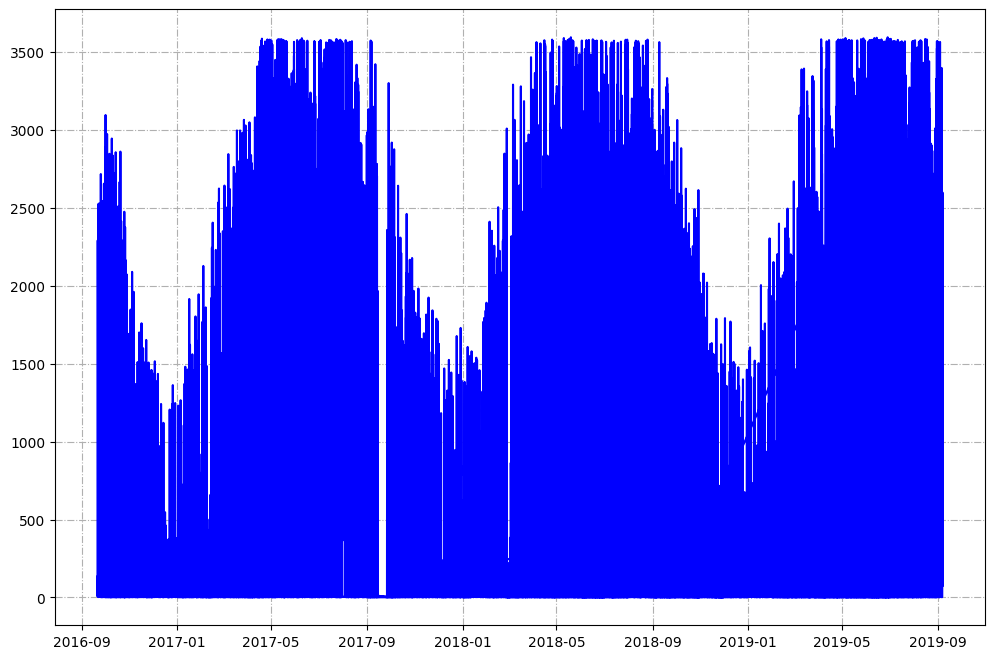

In [99]:
plt.figure(figsize=(12, 8))
plt.grid(linestyle='-.')

plt.plot(df_energy_sample['timestamp'], df_energy_sample['generation_w'], 'b')

In [100]:
df_spec.head()

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at
0,2405,53.53,-1.63,E01007430,180.0,35.0,3.36,2010-11-18
1,2406,54.88,-1.38,E01008780,315.0,30.0,1.89,2010-12-03
2,2407,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
3,2408,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03
4,2409,54.88,-1.38,E01008780,225.0,30.0,1.89,2010-12-03


In [101]:
import plotly.express as px

# Define a function to check if a location is in London
def is_in_london(latitude, longitude):
    # Replace the conditions with the actual latitude and longitude boundaries of London
    london_latitude_range = (51.3, 51.7)
    london_longitude_range = (-0.5, 0.3)
    return (london_latitude_range[0] <= latitude <= london_latitude_range[1]) and (london_longitude_range[0] <= longitude <= london_longitude_range[1])

# Create a new column indicating whether each location is in London
df_spec['in_london'] = df_spec.apply(lambda row: is_in_london(row['latitude_rounded'], row['longitude_rounded']), axis=1)

# Create the scatter plot, coloring the circles differently for locations in London
fig = px.scatter_geo(df_spec, lat=df_spec['latitude_rounded'], lon=df_spec['longitude_rounded'],
                     color='in_london',  # Use the 'in_london' column for coloring
                     scope="europe", projection="natural earth")

fig.update_layout(margin=dict(l=0, r=0, t=0, b=0))  # Set all margins to zero

fig.show()

In [102]:
px.histogram(df_spec.tilt)

In [103]:
px.histogram(df_spec.orientation)

In [104]:
# Test the weather API
import requests
import pandas as pd 

base_url = 'https://archive-api.open-meteo.com/v1/archive'

params = {
	"latitude": 52.52, # from df_spec
	"longitude": 13.41, # from df_spec
	"start_date": "2016-10-25", # from timeseries 
	"end_date": "2016-10-25", # from timeseries
	"timezone": "Europe/London", # default for london
	"hourly": ["weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "global_tilted_irradiance_instant", "terrestrial_radiation_instant"]       
     }

responses = requests.get(base_url, params).json()

df = pd.DataFrame({
    'time': responses['hourly']['time'],
    # 'weather_code': responses['hourly']['weather_code'],
    # 'shortwave_radiation': responses['hourly']['shortwave_radiation']
    # ... continue with remaining
    })

df.head(5)


,time
0,2016-10-25T00:00
1,2016-10-25T01:00
2,2016-10-25T02:00
3,2016-10-25T03:00
4,2016-10-25T04:00


In [105]:
# looping through hourly params and appending to df
for param in params['hourly']:
    df[param] = responses['hourly'][param]

df.head(10)

,time,weather_code,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant
0,2016-10-25T00:00,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-10-25T01:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-10-25T02:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-10-25T03:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-10-25T04:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2016-10-25T05:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2016-10-25T06:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,12.8
7,2016-10-25T07:00,53,6.0,0.0,6.0,0.0,6.0,111.9,11.1,0.0,11.1,0.0,8.0,207.3
8,2016-10-25T08:00,51,20.0,0.0,20.0,0.0,20.0,292.4,25.4,0.0,25.4,0.0,25.4,371.8
9,2016-10-25T09:00,3,73.0,1.0,72.0,3.2,73.0,437.1,82.7,1.1,81.5,3.2,82.7,494.9


In [109]:
# Get definitiion for weather WMO codes
from IPython.display import Image

wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'
wmo_description = requests.get(wmo_url).json()

image = wmo_description['0']['day']['image']
Image(image)
print(wmo_description['0']['day']['description'])
df.head(5)

Sunny


,time,weather_code,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant
0,2016-10-25T00:00,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2016-10-25T01:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2016-10-25T02:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2016-10-25T03:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2016-10-25T04:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [111]:
# Define a function to map weather codes to descriptions
def get_weather_description(weather_code):
    return wmo_description[str(weather_code)]['day']['description']

# Apply the function to create a new column with descriptions
df['description'] = df['weather_code'].apply(get_weather_description)

df.head(5)

,time,weather_code,shortwave_radiation,direct_radiation,diffuse_radiation,direct_normal_irradiance,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant,description
0,2016-10-25T00:00,53,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Drizzle
1,2016-10-25T01:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle
2,2016-10-25T02:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle
3,2016-10-25T03:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle
4,2016-10-25T04:00,51,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Light Drizzle


# 01 Defining Sample Set

In [112]:
sample_id = 6125

df_energy_sample = df_energy[df_energy.ss_id == sample_id]
len(df_energy_sample)

108

In [113]:
df_energy

,generation_w,timestamp,ss_id
5061268,331.0,2016-11-28 15:00:00+00:00,3020
7838211,213.0,2016-10-20 15:00:00+00:00,2777
8028861,268.0,2016-10-22 11:00:00+00:00,3442
8991864,103.0,2016-10-30 16:00:00+00:00,10651
8991865,32.0,2016-10-30 16:00:00+00:00,13670
...,...,...,...
542717023,504.0,2021-05-27 09:00:00+00:00,27029
546349198,642.0,2021-10-08 18:00:00+00:00,7759
548156823,57.0,2021-10-16 16:00:00+00:00,4476
552129699,1858.0,2021-09-07 15:00:00+00:00,13769


In [114]:
df_spec_sample = df_spec[df_spec.ss_id == sample_id]
df_spec_sample

,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,in_london
3720,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False


In [175]:
# Merge full dataset
df_merged = pd.merge(df_energy,df_spec,how='left',on='ss_id')
df_merged['formatted_timestamp'] = df_merged['timestamp'].dt.strftime('%Y-%m-%dT%H:%M')
df_merged.head()

,generation_w,timestamp,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,in_london,formatted_timestamp
0,331.0,2016-11-28 15:00:00+00:00,3020,50.82,0.25,E01021213,180.0,30.0,1.48,2011-10-31,False,2016-11-28T15:00
1,213.0,2016-10-20 15:00:00+00:00,2777,50.81,0.00,E01021063,270.0,49.0,3.96,2011-09-22,False,2016-10-20T15:00
2,268.0,2016-10-22 11:00:00+00:00,3442,55.83,-4.08,S00125139,180.0,45.0,2.47,2011-12-10,False,2016-10-22T11:00
3,103.0,2016-10-30 16:00:00+00:00,10651,55.82,-3.72,S00133687,270.0,41.0,2.00,2014-07-14,False,2016-10-30T16:00
4,32.0,2016-10-30 16:00:00+00:00,13670,57.64,-3.29,S00121469,135.0,45.0,2.50,2014-12-10,False,2016-10-30T16:00


In [169]:
# merge energy gerneration with spec df
df_merged_sample = pd.merge(df_energy_sample,df_spec_sample,how='left',on='ss_id')

# create date time column that matches API output 
df_merged_sample['formatted_timestamp'] = df_merged_sample['timestamp'].dt.strftime('%Y-%m-%dT%H:%M')
df_merged_sample.head(10)

,generation_w,timestamp,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,in_london,formatted_timestamp
0,1317.0,2017-04-28 13:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-04-28T13:00
1,1421.0,2017-04-28 14:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-04-28T14:00
2,672.0,2017-04-28 15:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-04-28T15:00
3,185.0,2017-04-28 16:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-04-28T16:00
4,187.0,2017-04-28 17:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-04-28T17:00
5,117.0,2017-04-28 18:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-04-28T18:00
6,310.0,2017-04-29 06:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-04-29T06:00
7,54.0,2017-02-09 10:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-02-09T10:00
8,53.0,2017-02-09 11:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-02-09T11:00
9,185.0,2017-02-09 12:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,False,2017-02-09T12:00


In [146]:
df_merged_sample.to_csv('sample_generation.csv')

In [170]:
# find min date
print(min(df_merged_sample['timestamp']).date())

# find max date
print(max(df_merged_sample['timestamp']).date())

# legth of df_merged_sample
print(f'no. of rows : {len(df_merged_sample)}')

# call api with these dates and hourly then write to json file for offline chache

2017-01-18
2019-01-03
no. of rows : 108


In [171]:
print(min(df_energy['timestamp']).date())
print(max(df_energy['timestamp']).date())


2016-10-20
2021-10-16


# 02 Single Row Test

In [118]:
# create one row test
import requests
import pandas as pd 

df_merged_single = df_merged_sample.head(1)
base_url = 'https://archive-api.open-meteo.com/v1/archive'

params = {
        "latitude": df_merged_single['latitude_rounded'],
        "longitude": df_merged_single['longitude_rounded'],
        "start_date": df_merged_single['timestamp'].iloc[0].date(),
        "end_date": df_merged_single['timestamp'].iloc[0].date(),
        "timezone": "Europe/London",
        "hourly": "weather_code"
    }

response = requests.get(base_url, params)
data = response.json()
hourly_weather = data['hourly']['weather_code']
hourly_time = data['hourly']['time']

wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'
wmo_description = requests.get(wmo_url).json()

for index, time in enumerate(hourly_time):
        #ensure you extract the string value and not just the series with .iloc[0]
        if time == df_merged_single['formatted_timestamp'].iloc[0]:
            weather_result = hourly_weather[index]
            weather_description = wmo_description[f'{weather_result}']['day']['description']
            print(f'weather description: {weather_description}')


weather description: Cloudy


# 03 Mulitple row sample set

In [119]:
import requests
import pandas as pd 

# Assuming df_merged_multiple is defined elsewhere
df_merged_multiple = df_merged_sample.head(10)

base_url = 'https://archive-api.open-meteo.com/v1/archive'
wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'

for index, row in df_merged_multiple.iterrows():
    params = {
        "latitude": row['latitude_rounded'],
        "longitude": row['longitude_rounded'],
        "start_date": row['timestamp'].date(),
        "end_date": row['timestamp'].date(),
        "timezone": "Europe/London",
        "hourly": "weather_code"
    }

    response = requests.get(base_url, params)
    data = response.json()
    hourly_weather = data['hourly']['weather_code']
    hourly_time = data['hourly']['time']

    wmo_description = requests.get(wmo_url).json()

    for i, time in enumerate(hourly_time):
        # Ensure you extract the string value and not just the series with .iloc[0]
        if time == row['formatted_timestamp']:
            weather_result = hourly_weather[i]
            weather_description = wmo_description[f'{weather_result}']['day']['description']
            print(f'weather description for row {index + 1}: {weather_description}')


weather description for row 1: Cloudy
weather description for row 2: Cloudy
weather description for row 3: Cloudy
weather description for row 4: Cloudy
weather description for row 5: Partly Cloudy
weather description for row 6: Partly Cloudy
weather description for row 7: Mainly Sunny
weather description for row 8: Light Drizzle
weather description for row 9: Light Drizzle
weather description for row 10: Light Drizzle


# 04 Apply Full Sample Set

In [176]:
import requests
import pandas as pd 

# Assuming df_merged_multiple is defined elsewhere
df_merged_multiple = df_merged

base_url = 'https://archive-api.open-meteo.com/v1/archive'
wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'

def get_weather_description(row):
    params = {
        "latitude": row['latitude_rounded'],
        "longitude": row['longitude_rounded'],
        "start_date": row['timestamp'].date(),
        "end_date": row['timestamp'].date(),
        "timezone": "Europe/London",
        "hourly": "weather_code"
    }

    response = requests.get(base_url, params)
    data = response.json()
    hourly_weather = data['hourly']['weather_code']
    hourly_time = data['hourly']['time']

    wmo_description = requests.get(wmo_url).json()

    for i, time in enumerate(hourly_time):
        # Ensure you extract the string value and not just the series with .iloc[0]
        if time == row['formatted_timestamp']:
            weather_result = hourly_weather[i]
            weather_description = wmo_description[f'{weather_result}']['day']['description']
            return weather_description

# Apply the function to create a new column 'weather_description'
df_merged_multiple['weather_description'] = df_merged_multiple.apply(get_weather_description, axis=1)

df_merged_multiple.head(5)


KeyError: 'hourly'

# 05 Call remaining API features

In [142]:
import requests
import pandas as pd 

# Assuming df_merged_multiple is defined elsewhere
df_merged_multiple = df_merged_sample.head(10)

base_url = 'https://archive-api.open-meteo.com/v1/archive'
wmo_url = 'https://gist.githubusercontent.com/stellasphere/9490c195ed2b53c707087c8c2db4ec0c/raw/76b0cb0ef0bfd8a2ec988aa54e30ecd1b483495d/descriptions.json'

def get_solar_feature(row, param):
    params = {
        "latitude": row['latitude_rounded'],
        "longitude": row['longitude_rounded'],
        "start_date": row['timestamp'].date(),
        "end_date": row['timestamp'].date(),
        "timezone": "Europe/London",
        "hourly": [param]       
    }

    response = requests.get(base_url, params)
    data = response.json()
    solar_feature = data['hourly'][param]
    hourly_time = data['hourly']['time']

    for i, time in enumerate(hourly_time):
        if time == row['formatted_timestamp']:
            return solar_feature[i] 

# Apply the function to create a new column 'weather_description'

hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "global_tilted_irradiance_instant", "terrestrial_radiation_instant"]       

for param in hourly_params:
    df_merged_multiple[param] = df_merged_multiple.apply(lambda row: get_solar_feature(row, param), axis=1)

KeyError: 'hourly'

# API DUMP JSON

### For loop option (API DUMP)

In [125]:
# calling from API dump instead of online call
import pandas as pd 

def get_solar_feature(row, param):

    data = pd.read_json('../data/raw_data/api_data.json')
    solar_feature = data['hourly'][param]
    hourly_time = data['hourly']['time']

    for i, time in enumerate(hourly_time):
        if time == row['formatted_timestamp']:
            return solar_feature[i] 

# Apply the function to create a new column 'weather_description'

hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", "diffuse_radiation_instant", "direct_normal_irradiance_instant", "global_tilted_irradiance_instant", "terrestrial_radiation_instant", "is_day", "sunshine_duration"]

for param in hourly_params:
    df_merged_multiple[param] = df_merged_multiple.apply(lambda row: get_solar_feature(row, param), axis=1)

In [126]:
df_merged_multiple.head()

,generation_w,timestamp,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,...,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant,is_day,sunshine_duration
0,1317.0,2017-04-28 13:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,536.0,1064.1,524.9,270.3,254.6,350.1,524.9,1042.0,1,3600.0
1,1421.0,2017-04-28 14:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,563.0,1002.3,535.8,324.6,211.3,459.2,535.8,954.0,1,3600.0
2,672.0,2017-04-28 15:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,508.0,890.0,467.3,284.2,183.1,468.6,467.3,818.7,1,3600.0
3,185.0,2017-04-28 16:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,405.0,734.9,355.7,215.2,140.5,450.0,355.7,645.5,1,3600.0
4,187.0,2017-04-28 17:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,247.0,547.5,201.2,94.5,106.7,286.0,201.2,446.0,1,3600.0


### Vecorization optimised (API DUMP)

In [184]:
# optimising with vectorization instead of for loop
import pandas as pd
import numpy as np

# Assuming df_merged_multiple is defined elsewhere
df_merged_multiple = df_merged_sample.head(1000)

# Convert 'formatted_timestamp' to datetime if it's not already in that format
df_merged_multiple['formatted_timestamp'] = pd.to_datetime(df_merged_multiple['formatted_timestamp'])

def get_solar_feature(row, param):
    data = pd.read_json('../data/raw_data/api_data.json')
    solar_feature = data['hourly'][param]
    hourly_time = pd.to_datetime(data['hourly']['time'])

    idx = np.where(hourly_time == row['formatted_timestamp'])[0]
    if len(idx) > 0:
        return solar_feature[idx[0]]
    else:
        return np.nan

# Apply the function to create new columns
hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", 
                 "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", 
                 "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", 
                 "diffuse_radiation_instant", "direct_normal_irradiance_instant", 
                 "global_tilted_irradiance_instant", "terrestrial_radiation_instant", "is_day", 
                 "sunshine_duration"]

for param in hourly_params:
    df_merged_multiple[param] = df_merged_multiple.apply(lambda row: get_solar_feature(row, param), axis=1)

In [185]:
df_merged_multiple.head(5)

,generation_w,timestamp,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,...,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant,is_day,sunshine_duration
0,1317.0,2017-04-28 13:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,536.0,1064.1,524.9,270.3,254.6,350.1,524.9,1042.0,1,3600.0
1,1421.0,2017-04-28 14:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,563.0,1002.3,535.8,324.6,211.3,459.2,535.8,954.0,1,3600.0
2,672.0,2017-04-28 15:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,508.0,890.0,467.3,284.2,183.1,468.6,467.3,818.7,1,3600.0
3,185.0,2017-04-28 16:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,405.0,734.9,355.7,215.2,140.5,450.0,355.7,645.5,1,3600.0
4,187.0,2017-04-28 17:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,247.0,547.5,201.2,94.5,106.7,286.0,201.2,446.0,1,3600.0


### Calling API in range of property dates 🏠

In [203]:
# Apply the function to create new columns
hourly_params = ["temperature_2m", "weather_code", "shortwave_radiation", "direct_radiation", 
                 "diffuse_radiation", "direct_normal_irradiance", "global_tilted_irradiance", 
                 "terrestrial_radiation", "shortwave_radiation_instant", "direct_radiation_instant", 
                 "diffuse_radiation_instant", "direct_normal_irradiance_instant", 
                 "global_tilted_irradiance_instant", "terrestrial_radiation_instant", "is_day", 
                 "sunshine_duration"]

# Assuming df_merged_multiple is defined elsewhere
id_list = df_merged_multiple.ss_id.unique()
id_list
id = id_list[0]
id

# Wrap entire code into for loop to iterate through each property
# for id in id_list:
df_merged_multiple = df_merged_multiple[df_merged_multiple['ss_id']== id]

# Convert 'formatted_timestamp' to datetime if it's not already in that format
df_merged_multiple['formatted_timestamp'] = pd.to_datetime(df_merged_multiple['formatted_timestamp'])

#Get API for specific property
base_url = 'https://archive-api.open-meteo.com/v1/archive'
params = {
        "latitude": df_merged_multiple['latitude_rounded'],
        "longitude": df_merged_multiple['longitude_rounded'],
        "start_date": min(df_merged_sample['timestamp']).date(),
        "end_date": max(df_merged_sample['timestamp']).date(),
        "timezone": "Europe/London",
        'hourly' : hourly_params
    }
response = requests.get(base_url, params)
# data = response.json()
data = pd.read_json('../data/raw_data/api_data.json')
data

# create get solar feature function which filters matching timeframe
def get_solar_feature(row, param, data):
    
    solar_feature = data['hourly'][param]
    hourly_time = pd.to_datetime(data['hourly']['time'])

    idx = np.where(hourly_time == row['formatted_timestamp'])[0]
    if len(idx) > 0:
        return solar_feature[idx[0]]
    else:
        return np.nan

'''//////////////////////////////////////////////////////////////////////////'''

# loop through each weather param and populate weather features to DF
for param in hourly_params:
    df_merged_multiple[param] = df_merged_multiple.apply(lambda row: get_solar_feature(row, param, data), axis=1)
print(f'processed property id:{id}')

# export data frame to_csv and   
# Export DataFrame to CSV and concatenate
csv_filename = f"property_data.csv"
if os.path.exists(csv_filename):
    df_merged_multiple.to_csv(csv_filename, mode='a', header=False, index=False)
else:
    df_merged_multiple.to_csv(csv_filename, index=False)

processed property id:6125


In [202]:
pd.read_csv

,generation_w,timestamp,ss_id,latitude_rounded,longitude_rounded,llsoacd,orientation,tilt,kwp,operational_at,...,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant,is_day,sunshine_duration
0,1317.0,2017-04-28 13:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,536.0,1064.1,524.9,270.3,254.6,350.1,524.9,1042.0,1,3600.00
1,1421.0,2017-04-28 14:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,563.0,1002.3,535.8,324.6,211.3,459.2,535.8,954.0,1,3600.00
2,672.0,2017-04-28 15:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,508.0,890.0,467.3,284.2,183.1,468.6,467.3,818.7,1,3600.00
3,185.0,2017-04-28 16:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,405.0,734.9,355.7,215.2,140.5,450.0,355.7,645.5,1,3600.00
4,187.0,2017-04-28 17:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,247.0,547.5,201.2,94.5,106.7,286.0,201.2,446.0,1,3600.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
103,991.0,2019-01-02 12:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,124.0,374.9,126.9,40.9,85.9,150.9,126.9,383.6,1,2727.54
104,126.0,2019-01-03 09:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,19.0,68.3,41.6,13.1,28.5,124.3,22.5,149.5,1,64.15
105,1053.0,2019-01-03 10:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,63.0,217.6,80.6,25.6,55.0,130.0,80.6,278.2,1,2100.80
106,408.0,2019-01-03 11:00:00+00:00,6125,51.34,1.31,E01024702,110.0,32.0,3.92,2012-07-11,...,85.0,322.9,94.5,31.1,63.4,122.7,94.5,358.8,1,1880.34


### Chunking the code

- number or properties based on ss_id we have
- with ss_id filter dataframe for id 
- for each property lat lon and time range from df
- make API call
- check response, and data from json is correct
- if response apply vecorization
- create df and concat the data for each new property 
- final output csv

# 06 Building Neural Network Sequential Model 🧠


In [20]:
X = df_merged_multiple.drop(columns=['generation_w']).select_dtypes(include='number')
y = df_merged_multiple['generation_w']
X

,ss_id,latitude_rounded,longitude_rounded,orientation,tilt,kwp,temperature_2m,weather_code,shortwave_radiation,direct_radiation,...,global_tilted_irradiance,terrestrial_radiation,shortwave_radiation_instant,direct_radiation_instant,diffuse_radiation_instant,direct_normal_irradiance_instant,global_tilted_irradiance_instant,terrestrial_radiation_instant,is_day,sunshine_duration
8485,6125,51.34,1.31,110.0,32.0,3.92,10.0,0,3.0,1.0,...,3.0,21.8,8.7,2.9,5.8,33.3,2.3,63.3,1,0.00
8497,6125,51.34,1.31,110.0,32.0,3.92,10.7,0,73.0,40.0,...,73.0,162.8,115.7,63.4,52.3,339.9,104.2,258.1,1,2943.36
8509,6125,51.34,1.31,110.0,32.0,3.92,12.4,0,173.0,108.0,...,173.0,342.0,212.3,132.5,79.8,437.0,212.3,419.7,1,3600.00
8521,6125,51.34,1.31,110.0,32.0,3.92,13.2,2,272.0,183.0,...,272.0,482.2,302.8,203.8,99.1,525.2,302.8,536.9,1,3600.00
8533,6125,51.34,1.31,110.0,32.0,3.92,13.8,2,366.0,274.0,...,366.0,573.9,383.9,287.4,96.5,660.8,383.9,601.9,1,3600.00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11914,6125,51.34,1.31,110.0,32.0,3.92,12.0,51,118.0,3.0,...,118.0,950.4,119.1,3.0,116.0,4.3,119.1,959.0,1,0.00
11944,6125,51.34,1.31,110.0,32.0,3.92,12.6,3,332.0,100.0,...,332.0,948.5,324.9,97.9,227.0,144.2,324.9,928.1,1,2527.24
11974,6125,51.34,1.31,110.0,32.0,3.92,13.2,3,270.0,64.0,...,270.0,889.4,255.5,60.6,194.9,98.4,255.5,841.4,1,1153.47
12004,6125,51.34,1.31,110.0,32.0,3.92,13.5,3,213.0,33.0,...,213.0,777.1,193.2,29.9,163.3,58.1,193.2,704.9,1,0.00


In [21]:
# preprocess data
# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=3)

# Standardize
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)

In [22]:
# compile model
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers

# Model definition
model = Sequential()
model.add(layers.Dense(20, activation='relu', input_dim=X.shape[1]))
model.add(layers.Dense(10, activation='relu'))
model.add(layers.Dense(1, activation='linear'))  # Linear activation for regression
model.summary()

model.compile(
    optimizer='adam',
    loss='mean_squared_error',  # Regression loss function
    metrics=['mean_absolute_error']  # Optional metric for evaluation
)

model.fit(X_train, y_train, batch_size=16, epochs=20,verbose=True)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_3 (Dense)                 │ (None, 20)             │           460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 10)             │           210 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │            11 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 681 (2.66 KB)

 Trainable params: 681 (2.66 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 760us/step - loss: 1001114.6875 - mean_absolute_error: 699.4294
Epoch 2/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 647us/step - loss: 850765.0625 - mean_absolute_error: 662.2530
Epoch 3/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - loss: 774830.7500 - mean_absolute_error: 619.5984
Epoch 4/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 744us/step - loss: 1039532.3125 - mean_absolute_error: 724.2776
Epoch 5/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 682us/step - loss: 744824.4375 - mean_absolute_error: 592.2778
Epoch 6/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 649us/step - loss: 872218.0625 - mean_absolute_error: 664.5754
Epoch 7/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 876885.1875 - mean_absolute_error: 642.7308
Epoch 8/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 673us/step - loss: 722048.5000 - mean_absolute_error: 586.2789
Epoch 9/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 956211.6875 - mean_absolute_error: 704.5696  
Epoch 10/20
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 812us/step - loss: 914611.8125 - mean_ab

In [23]:
# Evaluate performance
model.evaluate(scaler.transform(X_test), y_test)
# returns [loss, metrics]

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - loss: 1418509.1250 - mean_absolute_error: 926.6595


[1418509.125, 926.6595458984375]

In [24]:
# Check Predictions
# Predicted probabilities
y_pred = model.predict(scaler.transform(X_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step
